In [1]:
"""
Data Manipulation and Visualization Libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

"""
Datetime Libraries
"""
from datetime import datetime

"""
Modelling Libraries
"""
import joblib
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_predict, GridSearchCV


In [2]:
# set period under observation
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 5, 31)
# end_date = datetime.today() - relativedelta(months=2)

## EDA

In [3]:
# read crude price data
brent_oil_price = pd.read_csv('Data/DCOILBRENTEU.csv')
brent_oil_price['DATE'] = pd.to_datetime(brent_oil_price['DATE'])
brent_oil_price = brent_oil_price[(brent_oil_price['DATE'] > start_date) & (brent_oil_price['DATE'] < end_date)]

brent_oil_price.columns=['date', 'price']
brent_oil_price.set_index('date', inplace=True)

brent_oil_price.head()

,price
date,
2022-07-04,121.80
2022-07-05,110.49
2022-07-06,108.54
2022-07-07,113.40
2022-07-08,113.95


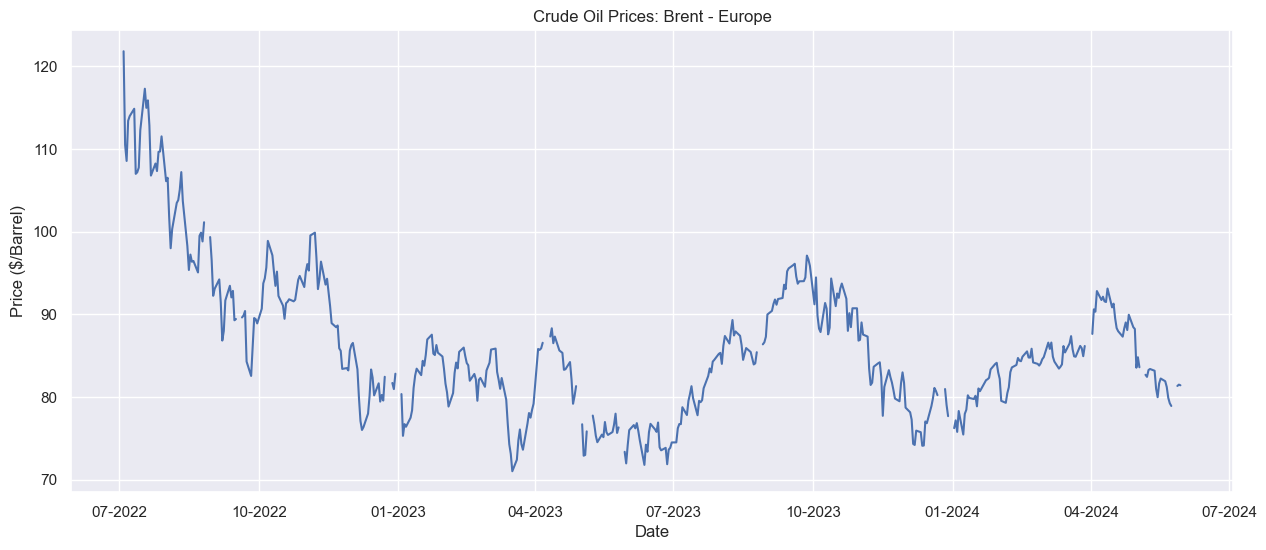

In [4]:
# Plot crude price 
sns.set_theme()
plt.figure(figsize=(15, 6))
plt.plot(brent_oil_price)
plt.title('Crude Oil Prices: Brent - Europe')
plt.xlabel("Date")
plt.ylabel("Price ($/Barrel)")

# Set x-axis to 3-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.show()

In [5]:
# read twitter sentiment data 
tweets_sentiment = pd.read_csv('Data/tweets_sentiment.csv', index_col='Unnamed: 0',  lineterminator='\n')

# compute tweet sentiment score and label
tweets_sentiment['sentiment_score'] = tweets_sentiment['Positive'] - tweets_sentiment['Negative']
tweets_sentiment['label'] = tweets_sentiment[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)\
                                .map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

# read twitter topic data 
tweets_topic = pd.read_csv('Data/tweets_topic.csv', index_col='Unnamed: 0')

# merge twitter sentiment and topic into one dataframe
tweets_df = tweets_sentiment.merge(tweets_topic, how='inner', on='id', suffixes=('', '_copy'))
tweets_df.drop(columns=[col for col in tweets_df.columns if col.endswith('_copy')], inplace=True)

# filter for tweets within date range
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df = tweets_df[(tweets_df['date'] >= start_date) & (tweets_df['date'] <= end_date)]
tweets_df.tail()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral,sentiment_score,label,topic
37685,1730343584572867060,2023-11-30,en,"At least based on today, can't say there's muc...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.044599,0.062963,0.892437,-0.018364,0,3
37686,1730185032914829401,2023-11-30,en,"Is $XOM's ""Death Cross"" a reason for #Energy b...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.053212,0.118022,0.828767,-0.064810,0,3
37687,1730352191548883361,2023-11-30,en,#OOTT #WTI As the #OPEC+ conspiracy collapsed ...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.311486,0.573089,0.115425,-0.261603,-1,0
37688,1730348517313466869,2023-11-30,en,#OOTT #WTI [W1]#OPEC+ got clubbed after its pa...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.025245,0.888074,0.086681,-0.862829,-1,0
37689,1730343562728944032,2023-11-30,en,"#OOTT #WTI ""For now, the outcome does not live...",3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.023566,0.911276,0.065159,-0.887710,-1,0


In [6]:
# Group tweets by date and calculate average sentiment
daily_sentiment = tweets_df.loc[:, ['date', 'label', 'sentiment_score']]
daily_sentiment = daily_sentiment.groupby(['date']).mean()

daily_sentiment.columns = [f'{col}_0' for col in daily_sentiment.columns]
daily_sentiment.head()

,label_0,sentiment_score_0
date,,
2022-07-01,-0.180556,-0.133128
2022-07-02,0.333333,0.212321
2022-07-03,-0.264706,-0.217177
2022-07-04,-0.160714,-0.123233
2022-07-05,-0.163934,-0.139811


In [7]:
# Group by date and topic and calculate average sentiment
daily_topic_sentiment = tweets_df.loc[:, ['date', 'label','topic', 'sentiment_score']]
daily_topic_sentiment['topic'] = daily_topic_sentiment['topic']+1
daily_topic_sentiment = daily_topic_sentiment.groupby(['date', 'topic']).mean()

# Unstack 'topic' to become columns
daily_topic_sentiment = daily_topic_sentiment.unstack(level='topic')

# Flatten the column MultiIndex resulting from unstack
daily_topic_sentiment.columns = daily_topic_sentiment.columns.map('{0[0]}_{0[1]}'.format) 

daily_topic_sentiment.head()

,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,
2022-07-01,-0.380952,0.000000,-0.263158,0.000000,-0.323286,0.019052,-0.196079,0.037853
2022-07-02,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699


In [8]:
# merge daily sentiment by topic and overall into one dataframe
daily_sentiment = pd.concat([daily_sentiment, daily_topic_sentiment], axis=1)
daily_sentiment.head()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2022-07-01,-0.180556,-0.133128,-0.380952,0.000000,-0.263158,0.000000,-0.323286,0.019052,-0.196079,0.037853
2022-07-02,0.333333,0.212321,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.264706,-0.217177,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.160714,-0.123233,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.163934,-0.139811,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699


In [9]:
# Find percentage of dates without a certain topic
print('% days with no tweets by topic')
print(round(daily_topic_sentiment.isna().sum() * 100 / len(daily_topic_sentiment), 2))

% days with no tweets by topic
label_1              0.00
label_2              0.43
label_3              0.43
label_4              0.57
sentiment_score_1    0.00
sentiment_score_2    0.43
sentiment_score_3    0.43
sentiment_score_4    0.57
dtype: float64


In [10]:
# Impute empty sentiment scores & labels with 0
features_df = daily_sentiment.fillna(0)

# Compute 7-day rolling average label & sentiment score
features_df = features_df.rolling(window=7).mean()
features_df.tail()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2024-05-27,-0.175591,-0.129427,-0.266826,0.092965,-0.186134,-0.123016,-0.250305,0.119174,-0.135923,-0.059630
2024-05-28,-0.130983,-0.101295,-0.169547,0.140584,-0.200420,-0.099206,-0.172202,0.124708,-0.133484,-0.043741
2024-05-29,-0.094890,-0.076828,-0.118527,0.133163,-0.133193,-0.084921,-0.117914,0.102768,-0.082155,-0.049314
2024-05-30,-0.074111,-0.064200,-0.109173,0.151020,-0.113550,-0.016893,-0.115058,0.098831,-0.064777,0.002360
2024-05-31,-0.061720,-0.051545,-0.110364,0.133163,0.017402,-0.045465,-0.115020,0.067778,0.065372,-0.001629


In [11]:
# merge price and features into one dataframe
df = pd.merge(brent_oil_price, features_df, left_index=True, right_index=True)
df.dropna(inplace=True)
df.head()

,price,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,,
2022-07-07,113.40,-0.092316,-0.086901,-0.188100,-0.120555,-0.011800,0.083488,-0.190777,-0.078725,-0.002572,0.071537
2022-07-08,113.95,-0.083189,-0.087374,-0.133678,-0.156269,0.001984,0.063080,-0.154155,-0.116261,0.001749,0.053397
2022-07-11,114.85,-0.122250,-0.115398,-0.129121,-0.182772,-0.103458,-0.043697,-0.149743,-0.138650,-0.068767,-0.043274
2022-07-12,106.98,-0.129643,-0.116865,-0.141026,-0.190193,-0.046315,-0.100840,-0.155559,-0.131345,-0.052966,-0.074022
2022-07-13,107.17,-0.113235,-0.104410,-0.123234,-0.148526,-0.046315,-0.092723,-0.136242,-0.109364,-0.059824,-0.067986


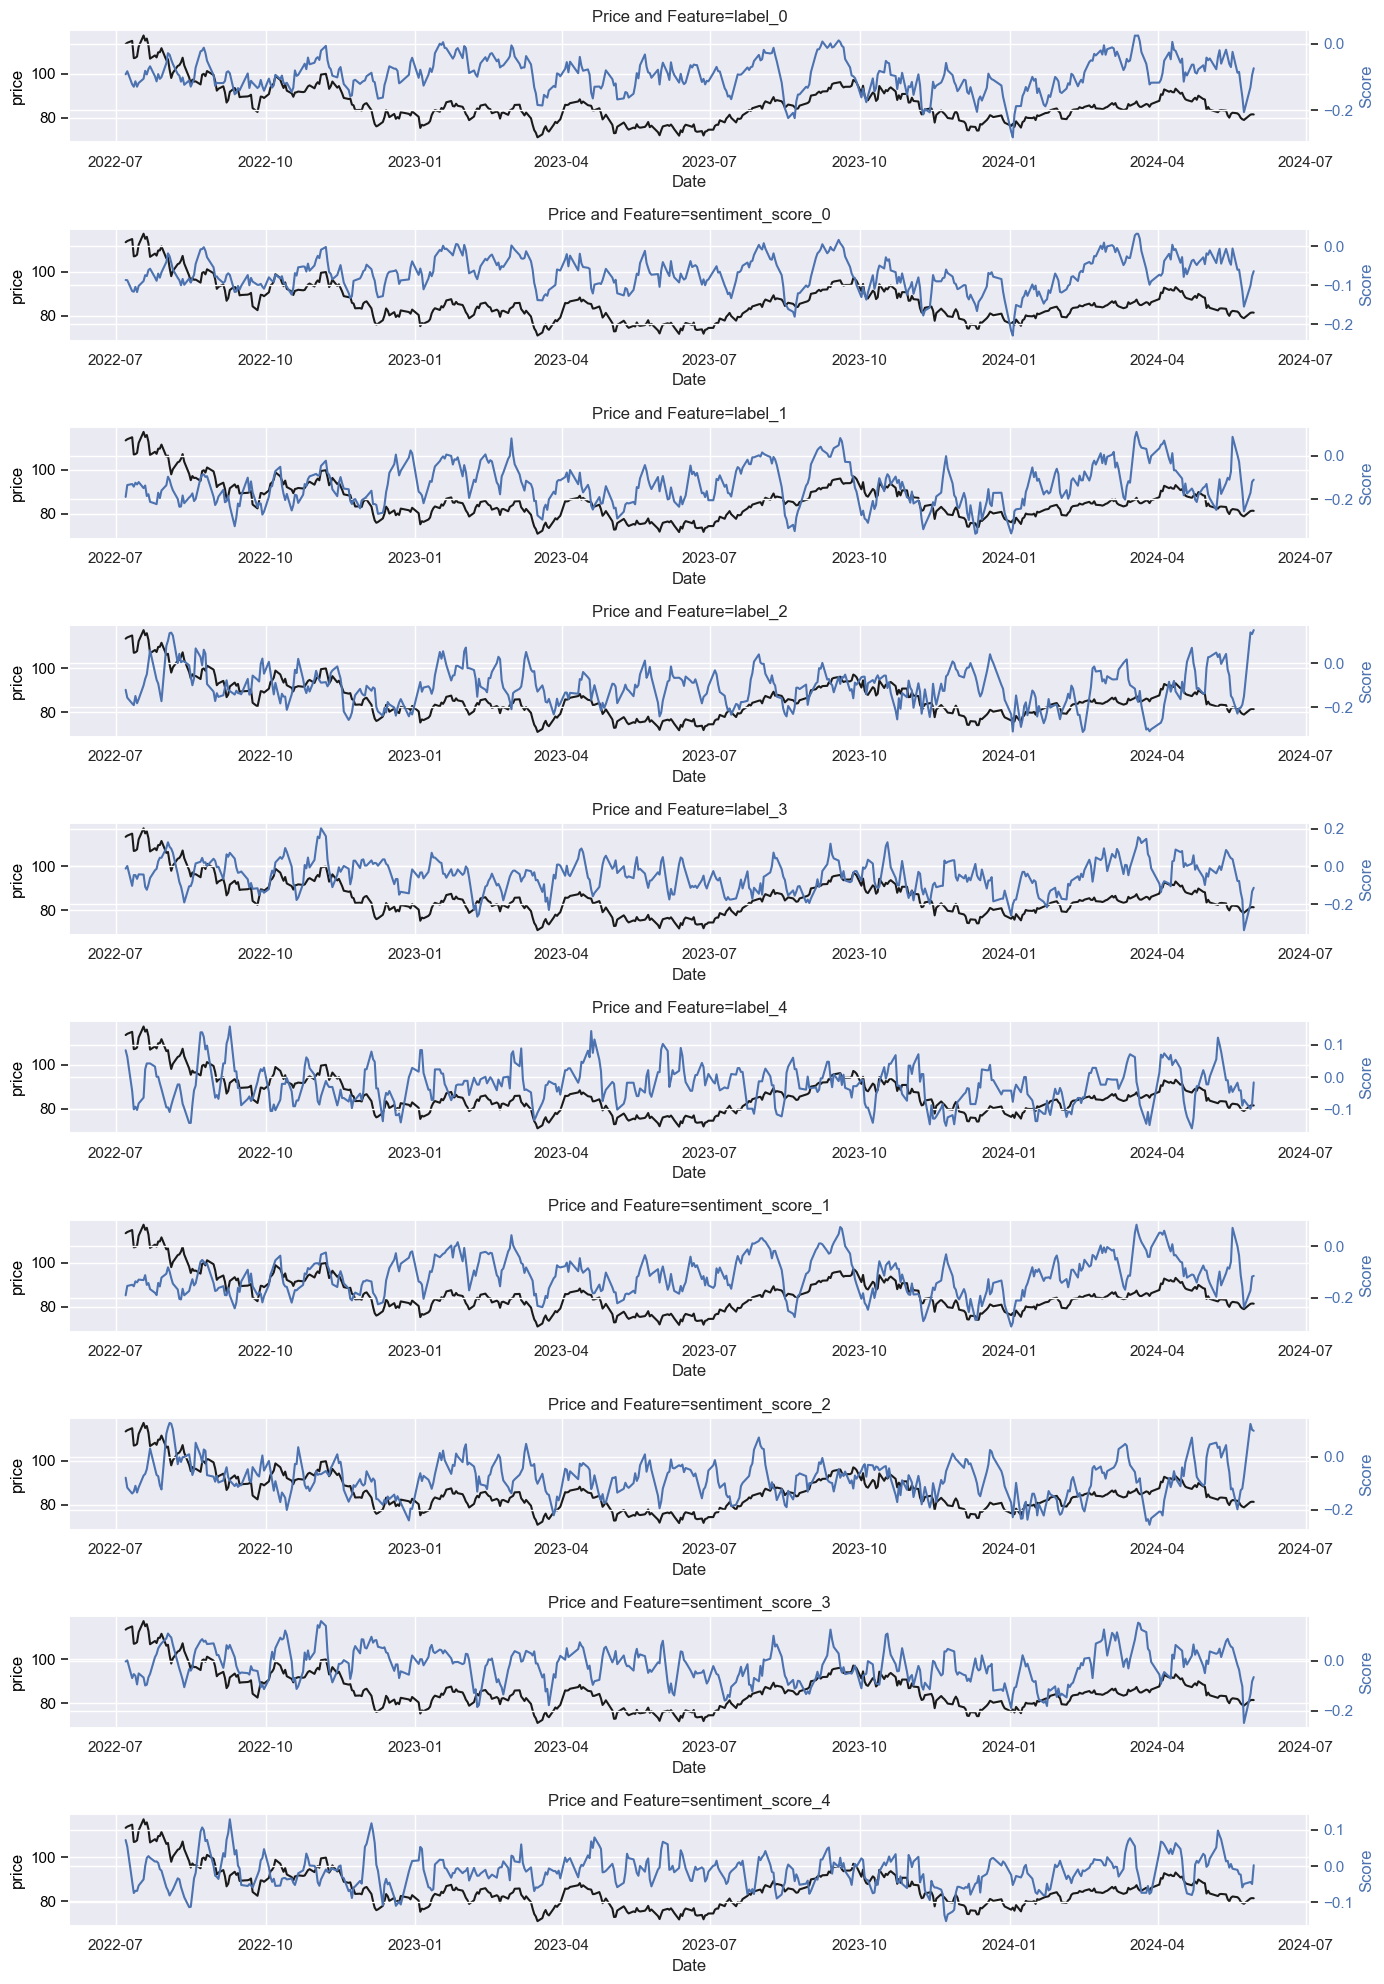

In [12]:
# Create subplots of price and sentiment score
fig, axs = plt.subplots(features_df.shape[1], 1, figsize=(14, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each feature against the target on different y-axes
for i in range(1, df.shape[1]):
    col = df.columns[i]
    ax1 = axs[i-1]
    ax2 = ax1.twinx()
    
    ax1.plot(df['price'], 'k-', label='Price')
    ax2.plot(df[col], 'b-', label=f'Topic {col}')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('price', color='black')
    ax2.set_ylabel('Score', color='b')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    ax1.set_title(f'Price and Feature={col}')

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Check

In [13]:
# Define helper function to check for stationarity
def check_stationarity(df, column, lags, conf_level=0.05):
    # Drop NAs if any
    df = df.dropna(subset=column)

    # Plot acf 
    plot_acf(df[column], lags=lags)
    plt.title(f"Autocorrelation Function (ACF) - {column}")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

    # Compute adf test statistic
    adftest = adfuller(df[column], maxlag=lags, autolag='AIC', regression='ct')
    if adftest[1] < conf_level:
        print("ADF Test Conclusion: Stationary")
    else:
        print("ADF Test Conclusion: Non-stationary")
    print("------------------------------------")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print(f"Note: If P-Value is smaller than {conf_level}, we reject the null hypothesis and the series is stationary")
    
    return 

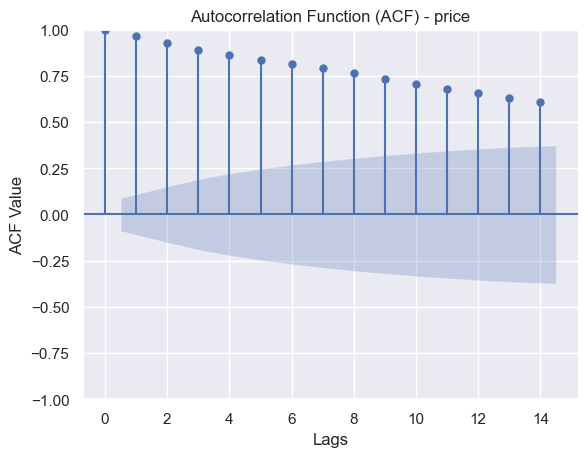

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.9025231993737717
P-Value: 0.16140059515878052
Number of lags: 5
Number of observations: 472
Critical Values: {'1%': -3.9780791758236447, '5%': -3.419832685881194, '10%': -3.132545796894096}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [14]:
check_stationarity(df, 'price', 14)

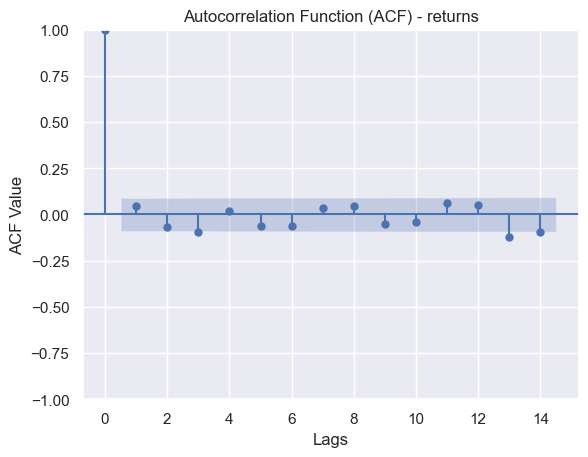

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -11.01585874133882
P-Value: 2.0766640062607016e-17
Number of lags: 4
Number of observations: 472
Critical Values: {'1%': -3.9780791758236447, '5%': -3.419832685881194, '10%': -3.132545796894096}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [15]:
# Calculate crude returns
df['returns'] = df['price'].pct_change(1)
check_stationarity(df, 'returns', 14)

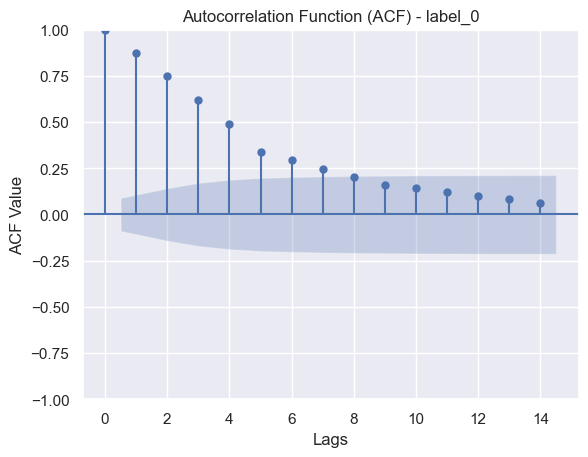

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.267521298524593
P-Value: 0.00353204474213152
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


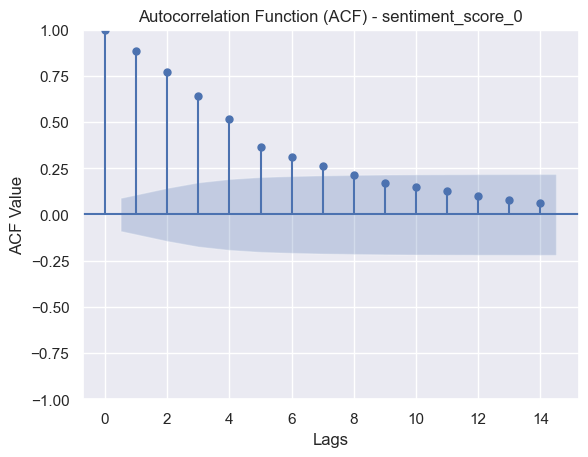

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.498378600068581
P-Value: 0.0015187627259275307
Number of lags: 11
Number of observations: 466
Critical Values: {'1%': -3.978329489428181, '5%': -3.419953518250008, '10%': -3.1326167935758216}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


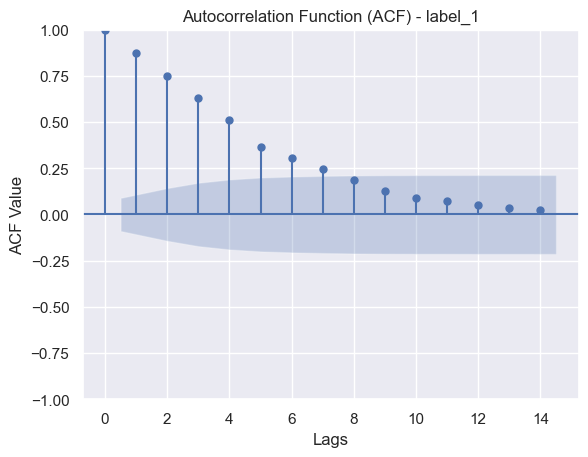

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.498297822554434
P-Value: 0.0015192246719401585
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


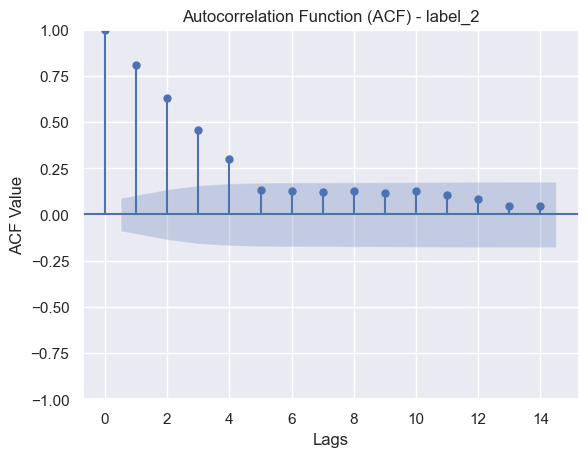

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.405743884262903
P-Value: 0.0021439583981794096
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


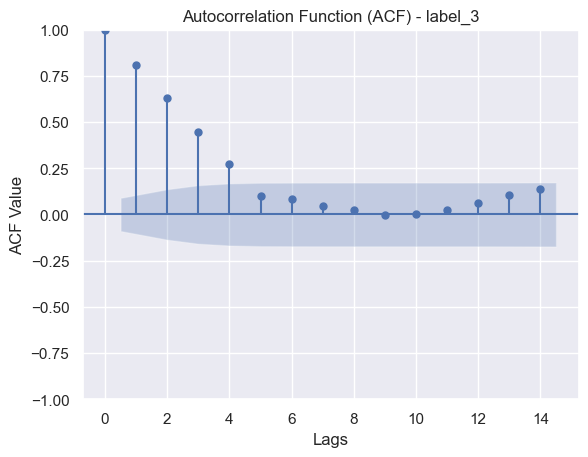

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.558981374925329
P-Value: 0.0012068921972590004
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


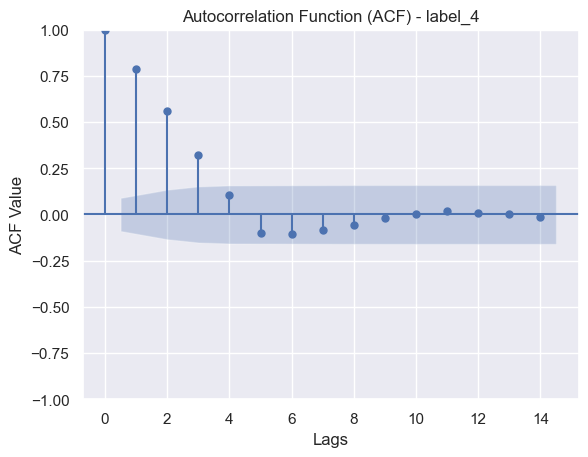

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.434540560288605
P-Value: 3.10003743866803e-05
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


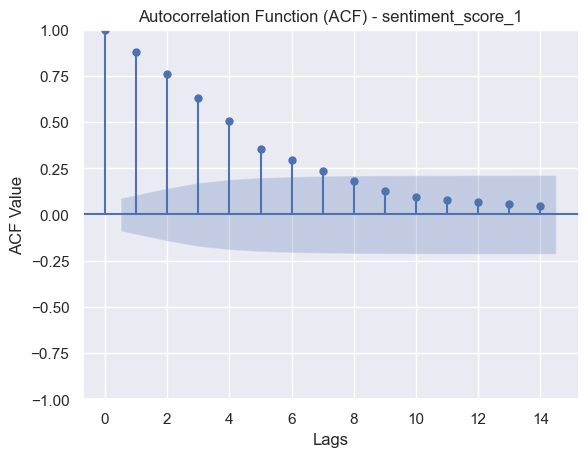

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.3960627786837305
P-Value: 0.0022215780541333173
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


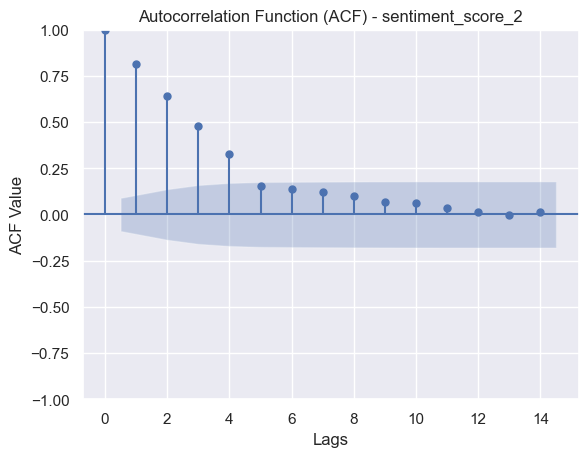

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.694546022462903
P-Value: 0.0007131386369350023
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


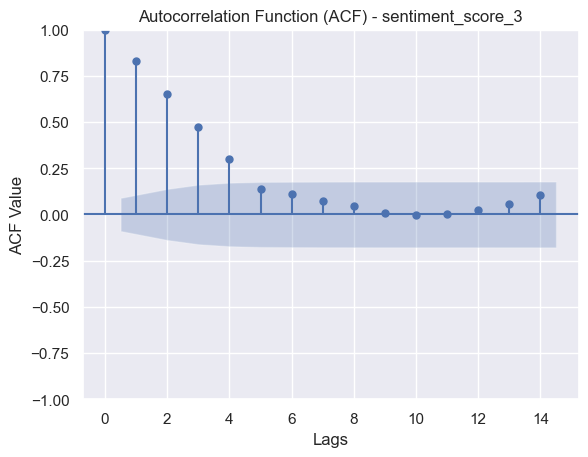

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.869958047390243
P-Value: 0.0003525757834224294
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


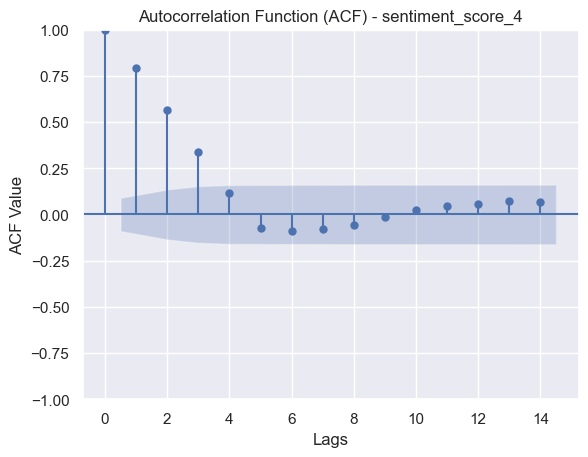

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.100245227515646
P-Value: 0.00013460563422018984
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [16]:
for col in features_df.columns:
    check_stationarity(df, col, 14)

## Granger Causality Check

In [17]:
# Define helper function to check for granger causality
def check_granger_causality(df, target, features, maxlag, test='ssr_chi2test', conf_level=0.05):
    # Create dataframe to store confidence p-values
    granger_df = pd.DataFrame()
    granger_df['lag'] = [i for i in range(1,maxlag+1)]
    for feature in features:
        res = grangercausalitytests(df[[target, feature]], maxlag=maxlag)
        p_value = [res.get(i)[0].get(test)[1] for i in res.keys()]
        col_name = f'{feature}_causes_{target}'
        granger_df[col_name] = p_value

    # Plot chart of p-values against lag for each feature and target
    plt.figure(figsize=(16,9))
    for y in granger_df.columns[1:]:   
        plt.plot(granger_df['lag'],granger_df[y],linewidth=3, label=y)
    plt.axhline(conf_level, color='red', linestyle='-.')
    plt.xlabel('lag')
    plt.legend(loc='upper right')
    plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3780  , p=0.2410  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=1.3867  , p=0.2390  , df=1
likelihood ratio test: chi2=1.3847  , p=0.2393  , df=1
parameter F test:         F=1.3780  , p=0.2410  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5957  , p=0.0757  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=5.2466  , p=0.0726  , df=2
likelihood ratio test: chi2=5.2178  , p=0.0736  , df=2
parameter F test:         F=2.5957  , p=0.0757  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7434  , p=0.1573  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=5.3086  , p=0.1505  , df=3
likelihood ratio test: chi2=5.2791  , p=0.1525  , df=3
parameter F test:         F=1.7434  , p=0.1573  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4731  , p=0.2092  

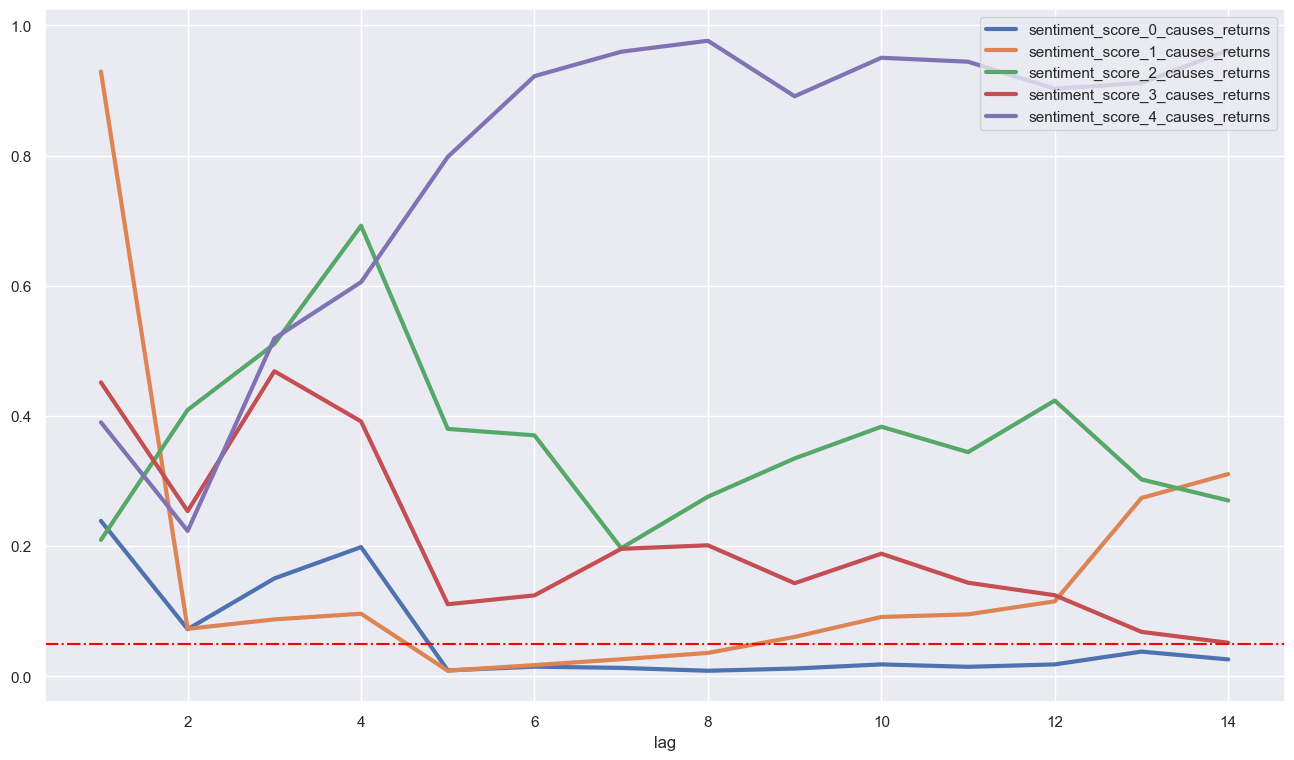

In [18]:
model_df = df.dropna()

# check granger causality of returns & sentiment scores
selected_target = 'returns'
selected_features = [col for col in features_df.columns if col.startswith('sentiment_score')]

check_granger_causality(model_df, selected_target, selected_features, 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8450  , p=0.3584  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=0.8504  , p=0.3564  , df=1
likelihood ratio test: chi2=0.8496  , p=0.3567  , df=1
parameter F test:         F=0.8450  , p=0.3584  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3046  , p=0.1009  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=4.6583  , p=0.0974  , df=2
likelihood ratio test: chi2=4.6356  , p=0.0985  , df=2
parameter F test:         F=2.3046  , p=0.1009  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4633  , p=0.2238  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=4.4558  , p=0.2163  , df=3
likelihood ratio test: chi2=4.4349  , p=0.2182  , df=3
parameter F test:         F=1.4633  , p=0.2238  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4447  , p=0.2182  

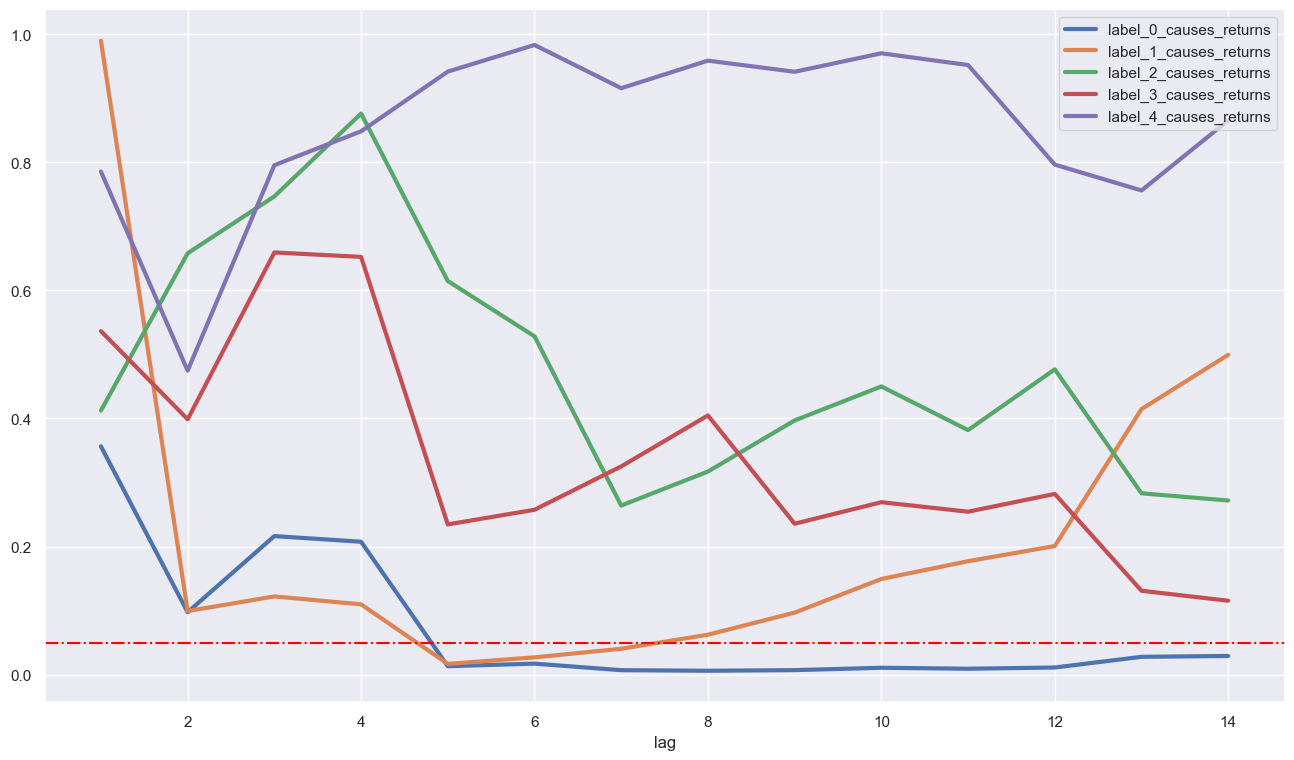

In [19]:
# check granger causality of returns & sentiment labels
selected_target = 'returns'
selected_features = [col for col in features_df.columns if col.startswith('label')]

check_granger_causality(model_df, selected_target, selected_features, 14)

## Lag Selection

In [20]:
# keep relevant columns
model_df = df.loc[:, ['returns', 'sentiment_score_0', 'sentiment_score_1']]
model_df.dropna(inplace=True)

VAR_model = VAR(model_df)
maxlag = 7

# for i in range(1,maxlag+1):
#     result = VAR_model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

results = VAR_model.fit(maxlags=7, ic='aic')
results.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     16:07:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.1373
Nobs:                     471.000    HQIC:                  -23.4423
Log likelihood:           3619.28    FPE:                5.41122e-11
AIC:                     -23.6401    Det(Omega_mle):     4.80585e-11
--------------------------------------------------------------------
Results for equation returns
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.002070         0.002190           -0.945           0.345
L1.returns                  -0.010477         0.049733           -0.211           0.833
L1.sentiment_score_0        -0

In [21]:
# Select the optimal lag order
lag_order_selection = VAR_model.select_order(maxlags=7)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -20.38      -20.35   1.411e-09      -20.37
1      -23.29     -23.19*   7.649e-11      -23.25
2      -23.32      -23.13   7.489e-11      -23.24
3      -23.36      -23.10   7.159e-11      -23.26
4      -23.36      -23.02   7.162e-11      -23.22
5      -23.42      -22.99   6.758e-11      -23.25
6     -23.64*      -23.14  5.400e-11*     -23.44*
7      -23.63      -23.05   5.452e-11      -23.40
-------------------------------------------------


In [22]:
# add lagged sentiment scores as features
lags = range(1, 7)  # use up to 6 lags based on AIC

model_df = model_df.assign(**{
                f'{col} (t-{lag})': model_df[col].shift(lag)
                for lag in lags
                for col in model_df.columns[1:]
            })

In [23]:
# add lagged returns as features
for lag in range(1,5):
    model_df = model_df.assign(**{f'returns (t-{lag})': model_df['returns'].shift(lag)})

model_df.head()

,returns,sentiment_score_0,sentiment_score_1,sentiment_score_0 (t-1),sentiment_score_1 (t-1),sentiment_score_0 (t-2),sentiment_score_1 (t-2),sentiment_score_0 (t-3),sentiment_score_1 (t-3),sentiment_score_0 (t-4),sentiment_score_1 (t-4),sentiment_score_0 (t-5),sentiment_score_1 (t-5),sentiment_score_0 (t-6),sentiment_score_1 (t-6),returns (t-1),returns (t-2),returns (t-3),returns (t-4)
date,,,,,,,,,,,,,,,,,,,
2022-07-08,0.004850,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-11,0.007898,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004850,NaN,NaN,NaN
2022-07-12,-0.068524,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007898,0.004850,NaN,NaN
2022-07-13,0.001776,-0.104410,-0.136242,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,-0.068524,0.007898,0.004850,NaN
2022-07-14,0.005319,-0.117771,-0.140339,-0.104410,-0.136242,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,0.001776,-0.068524,0.007898,0.00485


## Modelling

In [24]:
# Sort data by date
model_df.dropna(inplace=True)
model_df = model_df.sort_values('date')

# Split the data into train and test
train_set, test_set= np.split(model_df, [int(.67 *len(model_df))])
X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:, 0] 
X_test, y_test = test_set.iloc[:, 1:], test_set.iloc[:, 0] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [26]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [27]:
arima = ARIMA(y_train, order=(5,1,0))
arima_fit = arima.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

In [28]:
arimax = SARIMAX(y_train, exog=X_train, order=(5,1,0))
arimax_fit = arimax.fit(disp=False)
y_pred_arimax = arimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [29]:
ada = AdaBoostRegressor(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [30]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

models = {
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr,
    "ARIMA": y_pred_arima,
    "ARIMAX": y_pred_arimax,
    "AdaBoost": y_pred_ada
}

for name, y_pred in models.items():
    mse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Random Forest - MSE: 0.0003, MAE: 0.0139, R2: 0.0255
SVR - MSE: 0.0004, MAE: 0.0155, R2: -0.2305
ARIMA - MSE: 0.0003, MAE: 0.0138, R2: -0.0166
ARIMAX - MSE: 0.0006, MAE: 0.0189, R2: -0.7820
AdaBoost - MSE: 0.0003, MAE: 0.0140, R2: -0.0330


In [31]:
# Define a function to plot true vs. predicted values as line plots with a date index
def plot_true_vs_pred_line(dates, y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

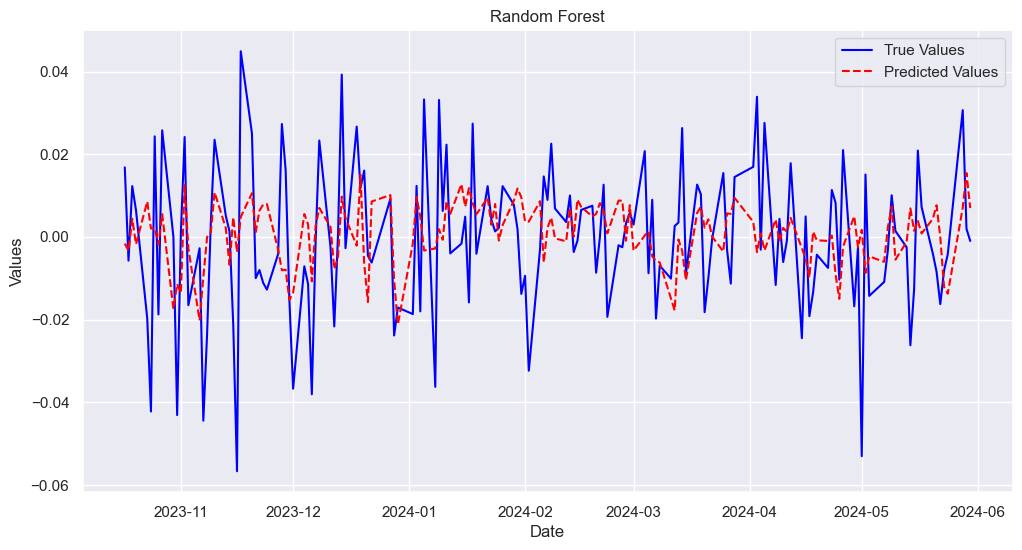

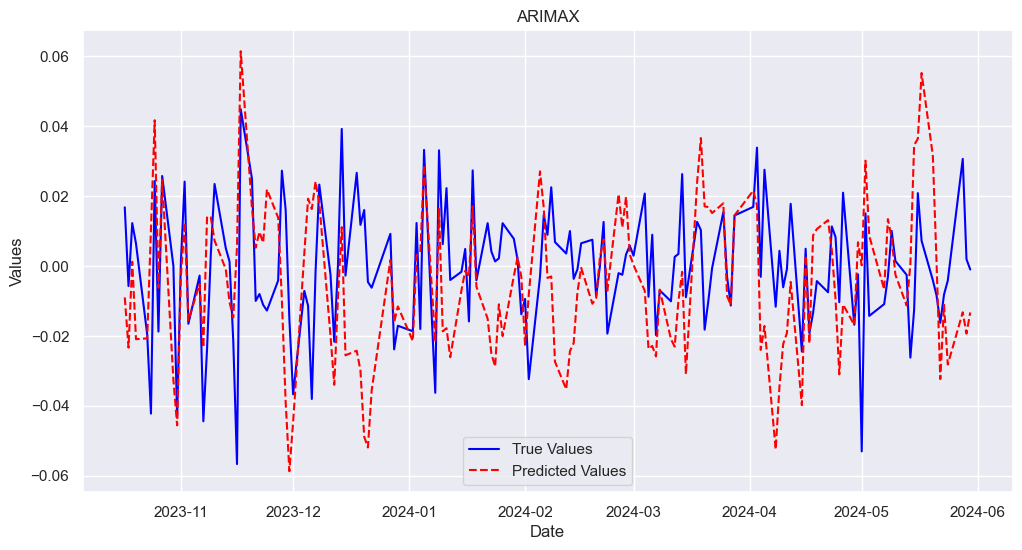

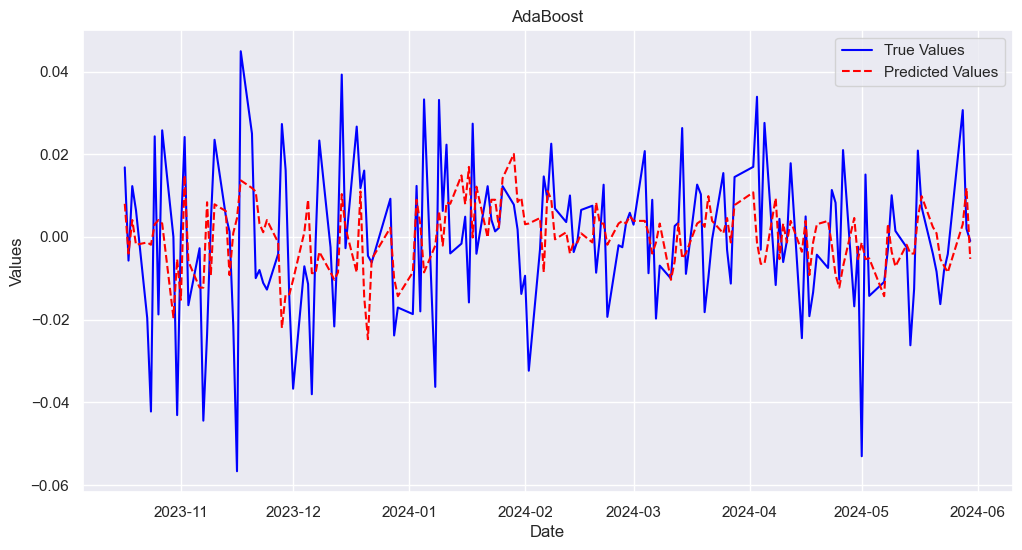

In [32]:
y_test_dates = test_set.index
# Plotting the results for each model
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_rf, "Random Forest")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr, "SVR")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arima, "ARIMA")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arimax, "ARIMAX")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_ada, "AdaBoost")


In [33]:
# save models
joblib.dump(rf, "models/random_forest.joblib")
joblib.dump(svr, 'models/svr.joblib')
joblib.dump(arima, 'models/arima.joblib')
joblib.dump(arimax, 'models/arimax.joblib')
joblib.dump(ada, 'models/adaboost_model.joblib')

['models/adaboost_model.joblib']

## Fine-tuning Random Forest

In [35]:
# Define TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5)
X, y = model_df.iloc[:, 1:], model_df.iloc[:, 0]
dates = model_df.index.date

# Split & print out results
for i, (train_index, test_index) in enumerate(tss.split(X)):
    print(f"Fold {i+1}:")
    train_start, train_end = dates[train_index[0]], dates[train_index[-1]]
    test_start, test_end = dates[test_index[0]], dates[test_index[-1]]
    print(f"  train : {train_start} - {train_end}")
    print(f"   test : {test_start} - {test_end}")

Fold 1:
  train : 2022-07-18 - 2022-11-09
   test : 2022-11-10 - 2023-03-02
Fold 2:
  train : 2022-07-18 - 2023-03-02
   test : 2023-03-03 - 2023-06-27
Fold 3:
  train : 2022-07-18 - 2023-06-27
   test : 2023-06-28 - 2023-10-16
Fold 4:
  train : 2022-07-18 - 2023-10-16
   test : 2023-10-17 - 2024-02-06
Fold 5:
  train : 2022-07-18 - 2024-02-06
   test : 2024-02-07 - 2024-05-30


In [36]:
# perform the cross-validation and get a score
# cv = cross_validate(rf,X,y,cv=tss,scoring='neg_root_mean_squared_error', return_estimator=True)
# print(cv['test_score'])
# print(cv['test_score'].mean())

# y_pred_cv = cross_val_predict(rf, X, y, cv=tss)

In [37]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}

scoring = {'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'}

rf_grid = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=tss, refit=True)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

Best hyperparameters are {'max_depth': 20, 'n_estimators': 200}
Best score is: -0.00045231367721578896


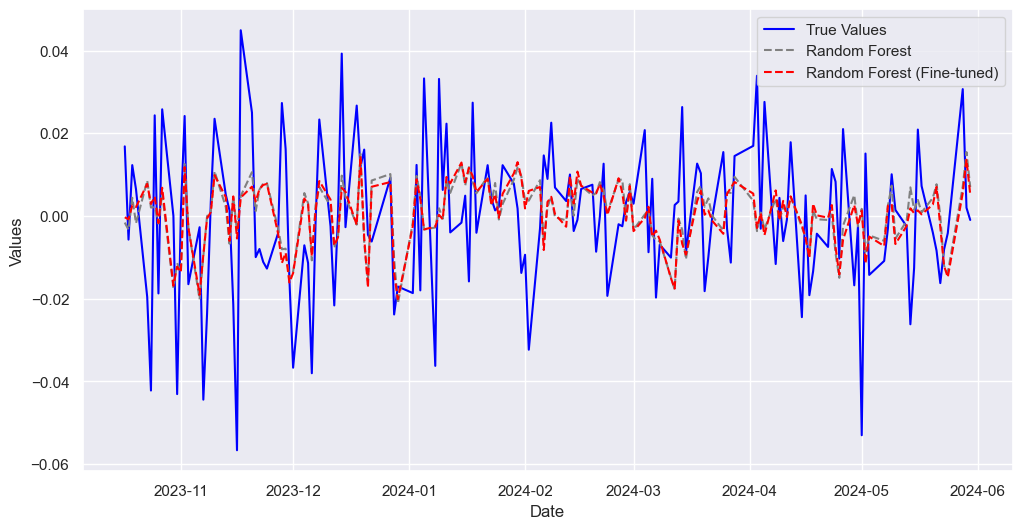

In [38]:
rf_tuned = rf_grid.best_estimator_
print('Best hyperparameters are '+str(rf_grid.best_params_))
print('Best score is: ' + str(rf_grid.best_score_))

y_pred_rf_tuned = rf_tuned.predict(X_test)
y_test_dates = test_set.index

# Plotting the results for each model
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='True Values', color='blue')
plt.plot(y_test_dates, y_pred_rf, label='Random Forest', color='gray', linestyle='--')
plt.plot(y_test_dates, y_pred_rf_tuned, label='Random Forest (Fine-tuned)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()


In [39]:
rf_feature_impt = pd.DataFrame({'features' :rf_tuned.feature_names_in_, 'importance':rf_tuned.feature_importances_})
rf_feature_impt.sort_values('importance', ascending=False)

,features,importance
1,sentiment_score_1,0.126657
15,returns (t-2),0.089908
16,returns (t-3),0.085647
17,returns (t-4),0.069492
14,returns (t-1),0.063926
3,sentiment_score_1 (t-1),0.057907
2,sentiment_score_0 (t-1),0.055033
5,sentiment_score_1 (t-2),0.054197
12,sentiment_score_0 (t-6),0.050443
0,sentiment_score_0,0.047195


## Fine-tuning ARIMAX

In [40]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

arimax_tuned = SARIMAX(y_train, exog=X_train, order=(1,0,1)).fit(disp=False) # order selected from pacf & acf
y_pred_arimax_tuned = arimax_tuned.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarni

In [41]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(y_train, X_train,
                          start_p=0, start_q=0,
                          m=12,
                          seasonal=True,          # seasonal=True when seasonal data
                          trace=True,
                          error_action='ignore',   # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)           # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1532.918, Time=3.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1535.403, Time=0.47 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1533.164, Time=3.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1533.325, Time=6.64 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1537.119, Time=0.32 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1534.832, Time=3.72 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1534.898, Time=3.44 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-1533.977, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-1534.794, Time=0.60 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1532.017, Time=0.65 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 23.621 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  315
Model:                        SARIMAX   Log Likelihood                 787.559
Date:                Tue, 22 Oct 2024   AIC                          -1537.119
Time:                        16:18:36   BIC                          -1465.820
Sample:                             0   HQIC                         -1508.632
                                - 315                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sentiment_score_0          -0.0849      0.120     -0.708      0.479      -0.320       0.150
sentiment_score_1           0.3148      0.063      4.982      0.000       0.191       0.439
sentiment_score_0 (t-1)    -0.0427      0.162     -0.264      0.791      -0.359       0.274
sentiment_score_1 (t-1)    -0.1610      0.087     -1.844      0.065      -0.332       0.010
sentiment_score_0 (t-2)     0.0006      0.169      0.003      0.997      -0.330       0.331
sentiment_score_1 (t-2)    -0.0725      0.091     -0.800      0.424      -0.250       0.105
sentiment_score_0 (t-3)    -0.1220      0.167     -0.732      0.464      -0.449       0.205
sentiment_score_1 (t-3)    -0.0050      0.089     -0.056      0.955      -0.179       0.169
sentiment_score_0 (t-4)     0.3391      0.145      2.346      0.019       0.056       0.622
sentiment_score_1 (t-4)    -0.0248      0.078     -0.317      0.751      -0.178       0.129
sentiment_score_0 (t-5)    -0.2962      0.153     -1.933      0.053      -0.596       0.004
sentiment_score_1 (t-5)     0.1658      0.086      1.932      0.053      -0.002       0.334
sentiment_score_0 (t-6)     0.0461      0.117      0.393      0.694      -0.184       0.276
sentiment_score_1 (t-6)    -0.1126      0.068     -1.664      0.096      -0.245       0.020
returns (t-1)               0.0229      0.062      0.368      0.713      -0.099       0.145
returns (t-2)              -0.1278      0.055     -2.305      0.021      -0.236      -0.019
returns (t-3)              -0.1244      0.058     -2.154      0.031      -0.238      -0.011
returns (t-4)              -0.0834      0.058     -1.427      0.154      -0.198       0.031
sigma2                      0.0004   2.96e-05     13.326      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 5.79
Prob(Q):                              0.78   Prob(JB):                         0.06
Heteroskedasticity (H):               0.68   Skew:                            -0.04
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
arimax_tuned2 = SARIMAX(y_train, exog=X_train, order=(0,0,0)).fit(disp=False)
y_pred_arimax_tuned2 = arimax_tuned2.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported

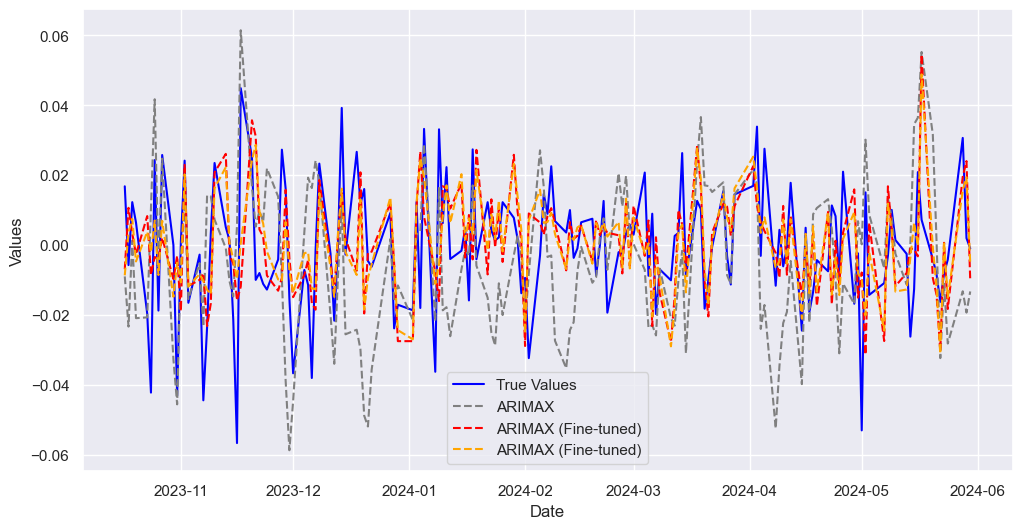

In [43]:
# Plotting the results for each model
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='True Values', color='blue')
plt.plot(y_test_dates, y_pred_arimax, label='ARIMAX', color='gray', linestyle='--')
plt.plot(y_test_dates, y_pred_arimax_tuned, label='ARIMAX (Fine-tuned)', color='red', linestyle='--')
plt.plot(y_test_dates, y_pred_arimax_tuned2, label='ARIMAX (Fine-tuned)', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()


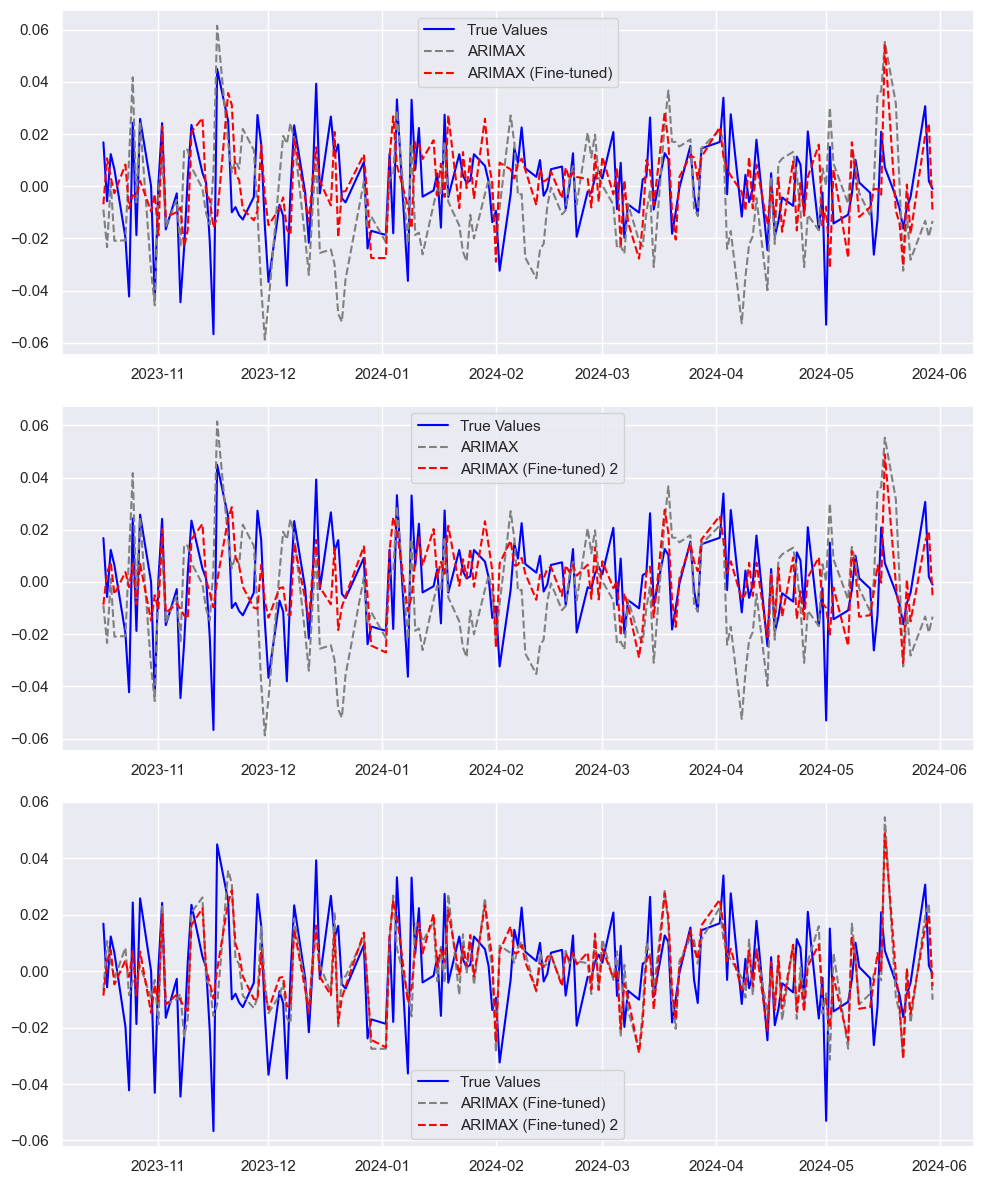

In [44]:
# Creating subplots to compare each array with the others
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Compare array1 with array2 and array3
axes[0].plot(y_test_dates, y_test, label='True Values', color='blue')
axes[0].plot(y_test_dates, y_pred_arimax, label='ARIMAX', color='gray', linestyle='--')
axes[0].plot(y_test_dates, y_pred_arimax_tuned, label='ARIMAX (Fine-tuned)', color='red', linestyle='--')
axes[0].legend()
# axes[0].set_title('Array 1 vs Array 2 vs Array 3')

# Compare array2 with array1 and array3
axes[1].plot(y_test_dates, y_test, label='True Values', color='blue')
axes[1].plot(y_test_dates, y_pred_arimax, label='ARIMAX', color='gray', linestyle='--')
axes[1].plot(y_test_dates, y_pred_arimax_tuned2, label='ARIMAX (Fine-tuned) 2', color='red', linestyle='--')
axes[1].legend()
# axes[1].set_title('Array 2 vs Array 1 vs Array 3')

# Compare array3 with array1 and array2
axes[2].plot(y_test_dates, y_test, label='True Values', color='blue')
axes[2].plot(y_test_dates, y_pred_arimax_tuned, label='ARIMAX (Fine-tuned)', color='grey', linestyle='--')
axes[2].plot(y_test_dates, y_pred_arimax_tuned2, label='ARIMAX (Fine-tuned) 2', color='red', linestyle='--')
axes[2].legend()
# axes[2].set_title('Array 3 vs Array 1 vs Array 2')

# Adjust layout
plt.tight_layout()
plt.show()

## Fine-tuning AdaBoost

In [45]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.0001, 0.01, 0.1, 1.0]
}

scoring = {'neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'}

ada_grid = GridSearchCV(ada, param_grid, scoring='neg_mean_squared_error', cv=tss, refit=True)
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostRegressor(random_state=42),
             param_grid={'learning_rate': [0.0001, 0.01, 0.1, 1.0],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

Best hyperparameters are {'learning_rate': 0.01, 'n_estimators': 50}
Best score is: -0.00043950921689439473


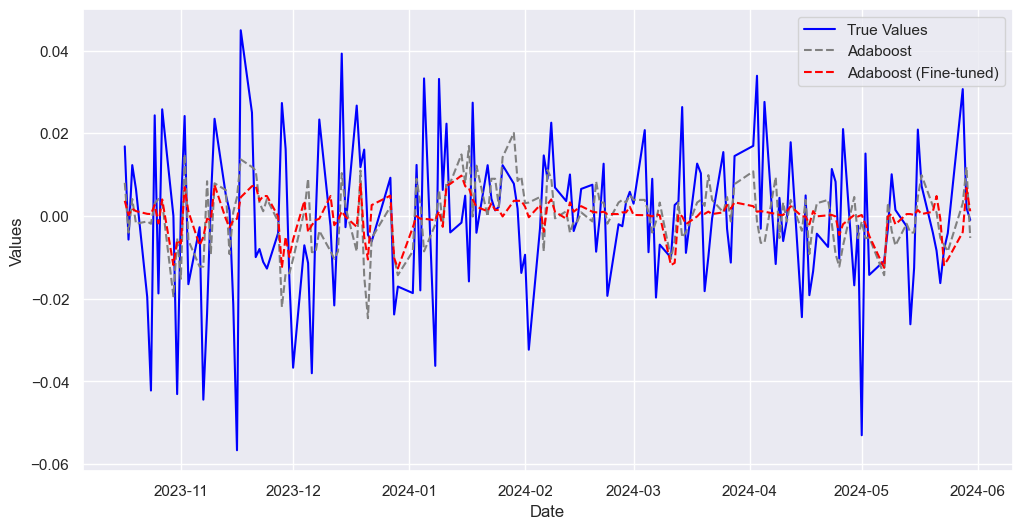

In [46]:
ada_tuned = ada_grid.best_estimator_
print('Best hyperparameters are '+str(ada_grid.best_params_))
print('Best score is: ' + str(ada_grid.best_score_))

y_pred_ada_tuned = ada_tuned.predict(X_test)

# Plotting the results for each model
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test, label='True Values', color='blue')
plt.plot(y_test_dates, y_pred_ada, label='Adaboost', color='gray', linestyle='--')
plt.plot(y_test_dates, y_pred_ada_tuned, label='Adaboost (Fine-tuned)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
# plt.title(title)
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# save tuned models
joblib.dump(rf_tuned, "models/random_forest_tuned.joblib")
joblib.dump(ada_tuned, 'models/adaboost_model_tuned.joblib')

['models/adaboost_model_tuned.joblib']

In [56]:
# save data used for modelling
model_df.loc[X_train.index, 'train_set'] = 1
model_df.loc[X_test.index, 'train_set'] = 0
model_df.to_csv('Data/model.csv')

In [70]:
len(y_pred_ada_tuned)

156

In [72]:
y_test.index

DatetimeIndex(['2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
               '2023-10-27', '2023-10-30',
               ...
               '2024-05-16', '2024-05-17', '2024-05-20', '2024-05-21',
               '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-28',
               '2024-05-29', '2024-05-30'],
              dtype='datetime64[ns]', name='date', length=156, freq=None)

In [118]:
train_predictions = pd.DataFrame({
                        "Actual": y_train,
                        "Random_Forest": rf.predict(X_train),
                        "Random_Forest_Tuned": rf_tuned.predict(X_train),
                        "SVR": svr.predict(X_train),
                        "ARIMA": arima_fit.fittedvalues.values,
                        "ARIMAX": arimax_fit.fittedvalues.values,
                        "ARIMAX_Tuned": arimax_tuned.predict(start=0, end=len(y_train)-1, exog=X_train).values,
                        "AdaBoost": ada.predict(X_train),
                        "AdaBoost_Tuned": ada_tuned.predict(X_train)
                    })
train_predictions['train_set'] = 1

test_predictions = pd.DataFrame({
                        "Actual": y_test,
                        "Random_Forest": y_pred_rf,
                        "Random_Forest_Tuned": y_pred_rf_tuned,
                        "SVR": y_pred_svr,
                        "ARIMA": y_pred_arima.values,
                        "ARIMAX": y_pred_arimax.values,
                        "ARIMAX_Tuned": y_pred_arimax_tuned.values,
                        "AdaBoost": y_pred_ada, 
                        "AdaBoost_Tuned":y_pred_ada_tuned
                    })
test_predictions['train_set'] = 0

predictions = pd.concat([train_predictions, test_predictions])
predictions.to_csv('Data/predictions.csv')

In [122]:
X_test.head()

,sentiment_score_0,sentiment_score_1,sentiment_score_0 (t-1),sentiment_score_1 (t-1),sentiment_score_0 (t-2),sentiment_score_1 (t-2),sentiment_score_0 (t-3),sentiment_score_1 (t-3),sentiment_score_0 (t-4),sentiment_score_1 (t-4),sentiment_score_0 (t-5),sentiment_score_1 (t-5),sentiment_score_0 (t-6),sentiment_score_1 (t-6),returns (t-1),returns (t-2),returns (t-3),returns (t-4)
date,,,,,,,,,,,,,,,,,,
2023-10-17,-0.028568,-0.074363,-0.057227,-0.114224,-0.049722,-0.058044,-0.064387,-0.103649,-0.093850,-0.172229,-0.109709,-0.200877,-0.074672,-0.163502,-0.035408,0.067081,0.009363,-0.034399
2023-10-18,-0.037395,-0.065793,-0.028568,-0.074363,-0.057227,-0.114224,-0.049722,-0.058044,-0.064387,-0.103649,-0.093850,-0.172229,-0.109709,-0.200877,0.016815,-0.035408,0.067081,0.009363
2023-10-19,-0.033707,-0.058866,-0.037395,-0.065793,-0.028568,-0.074363,-0.057227,-0.114224,-0.049722,-0.058044,-0.064387,-0.103649,-0.093850,-0.172229,-0.005728,0.016815,-0.035408,0.067081
2023-10-20,-0.062192,-0.090882,-0.033707,-0.058866,-0.037395,-0.065793,-0.028568,-0.074363,-0.057227,-0.114224,-0.049722,-0.058044,-0.064387,-0.103649,0.012284,-0.005728,0.016815,-0.035408
2023-10-23,-0.066690,-0.065409,-0.062192,-0.090882,-0.033707,-0.058866,-0.037395,-0.065793,-0.028568,-0.074363,-0.057227,-0.114224,-0.049722,-0.058044,0.006443,0.012284,-0.005728,0.016815
